## Sentiment Classification SG Reviews Data (BOW, non-Deep Learning) - No Language Detector

This notebook covers two good approaches to perform sentiment classification - Naive Bayes and Logistic Regression. We will train SG reviews data on both.

As a rule of thumb, reviews that are 3 stars and above are **positive**, and vice versa.

In [1]:
%pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install spacy_langdetect

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 17.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
import gensim
import spacy
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In [6]:
RANDOM_SEED = 33

In [7]:
reviews_sg = pd.read_pickle("assets/sg_reviews.pkl")
reviews_sg.head()

,date,review,rating,app
0,2020-09-30,"Used to be a good app been using for years, no...",5,GrabFood
1,2020-08-21,Grab app is convenient because you can use mul...,1,GrabFood
2,2020-11-18,I used to love the subscription plans that the...,1,GrabFood
3,2021-11-06,I ordered a grabfood and one of the 3 items ar...,1,GrabFood
4,2021-09-26,This platform gives too much power to restaura...,1,GrabFood


In [8]:
reviews_sg['label'] = np.where(reviews_sg['rating'] >= 3, 0, 1)

In [9]:
reviews_sg.head()

,date,review,rating,app,label
0,2020-09-30,"Used to be a good app been using for years, no...",5,GrabFood,0
1,2020-08-21,Grab app is convenient because you can use mul...,1,GrabFood,1
2,2020-11-18,I used to love the subscription plans that the...,1,GrabFood,1
3,2021-11-06,I ordered a grabfood and one of the 3 items ar...,1,GrabFood,1
4,2021-09-26,This platform gives too much power to restaura...,1,GrabFood,1


## 1. Data Processing

Check the dataset size:

In [10]:
print(len(reviews_sg))

659684


And the type of apps:

In [11]:
app_list = list(reviews_sg['app'].unique())
app_list

['GrabFood', 'Deliveroo', 'FoodPanda']

Let's also get a sense of our dataset's balance

In [12]:
reviews_sg['label'].value_counts(normalize=True)

0    0.740038
1    0.259962
Name: label, dtype: float64

In [13]:
# By app

for app in app_list:
    print(reviews_sg[reviews_sg['app'] == app]['label'].value_counts(normalize=True))

0    0.749
1    0.251
Name: label, dtype: float64
0    0.658943
1    0.341057
Name: label, dtype: float64
0    0.747103
1    0.252897
Name: label, dtype: float64


Across the board the distribution of positive and negative reviews are quite consistent between the apps. Overall, there's an imbalance in our dataset, with positive reviews making for 75% of the dataset. Let's also check for null values.

In [14]:
reviews_sg.isnull().sum()

date       0
review    87
rating     0
app        0
label      0
dtype: int64

In [15]:
reviews_sg = reviews_sg.dropna()

In [16]:
df_proc = reviews_sg.copy()
df_proc.drop(columns=['date', 'rating', 'app'], inplace=True)
df_proc.head()

,review,label
0,"Used to be a good app been using for years, no...",0
1,Grab app is convenient because you can use mul...,1
2,I used to love the subscription plans that the...,1
3,I ordered a grabfood and one of the 3 items ar...,1
4,This platform gives too much power to restaura...,1


In [17]:
X = df_proc['review']
y = df_proc['label']

We will split the dataset into `train`, `test`, and `dev`, with 80%, 10%, 10% ratio, respectively.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

In [19]:
len(X_train)

527677

In [20]:
len(X_dev)

65960

In [21]:
len(X_test)

65960

In [22]:
X_train.iloc[0]

'Sukish'

In [23]:
X_test.iloc[0]

'💚'

## 2. Bag-of-Words Approach on Naive Bayes & Logistic Regression

This section explores the use of bag of words as feature extraction. But first, let's have a look at the token frequencies.

In [24]:
# Fill this with any token (with anything in it!) for tokens separated by whitespace
ws_tokens = Counter()

# Fill this one with tokens separated by whitespace but constisting only of tokens
# that are totally made of alphanumeric characters (you can use the \w character
# class in making the regex)

alpha_ws_tokens = Counter()

# Fill this one with the tokens separated by *word boundaries* (not white space) that consist
# of alphanumeric characters (use \w again)
alpha_re_tokens = Counter()
for review in tqdm(X_train):
    ws_review = review.split()
    ws_tokens.update(ws_review)
    # Note: use fullmatch() as it anchor both the start and end of str. match() won't work.
    alpha_ws_tokens.update([re.fullmatch(r'\w+', word).group() for word in ws_review if re.fullmatch(r'\w+', word) != None])
    alpha_re_tokens.update(re.findall(r'\w+', review))

100%|██████████| 527677/527677 [00:14<00:00, 35550.28it/s]


In [25]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

257197
109083
137382


In [26]:
top_100 = alpha_re_tokens.most_common(100)
top_100

[('the', 147081),
 ('to', 139697),
 ('and', 113582),
 ('app', 102748),
 ('I', 99338),
 ('is', 75412),
 ('it', 70300),
 ('Good', 65707),
 ('order', 59305),
 ('a', 58797),
 ('for', 58218),
 ('food', 56091),
 ('my', 54214),
 ('good', 54179),
 ('service', 46719),
 ('of', 44700),
 ('t', 40529),
 ('in', 40378),
 ('not', 39781),
 ('delivery', 38293),
 ('this', 36684),
 ('but', 36672),
 ('you', 35021),
 ('time', 31714),
 ('i', 30103),
 ('on', 28657),
 ('that', 28267),
 ('use', 27340),
 ('have', 26611),
 ('they', 26187),
 ('Very', 25966),
 ('with', 25488),
 ('s', 25123),
 ('very', 24833),
 ('me', 24782),
 ('was', 24579),
 ('can', 22862),
 ('are', 22818),
 ('so', 22034),
 ('from', 19347),
 ('no', 19344),
 ('be', 19055),
 ('Nice', 18961),
 ('your', 18942),
 ('It', 18842),
 ('The', 18170),
 ('when', 17514),
 ('Great', 17360),
 ('at', 15795),
 ('customer', 15624),
 ('more', 14613),
 ('up', 14299),
 ('or', 14169),
 ('get', 13762),
 ('just', 13748),
 ('apps', 13612),
 ('as', 13532),
 ('easy', 13368),

Lots of stopwords, as expected.

In [27]:
x = list(range(100))
y = [word_tup[1] for word_tup in top_100]

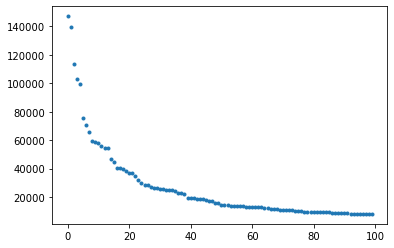

In [28]:
ax = plt.plot(x, y, '.')
#plt.yscale('log')
#plt.xscale('log')

And unexpectedly, the word frequency distribution also follows Zipf's law as well. What that means is that we can essentially remove uncommon words, without worrying that they will affect performance. We will also need to remove stopwords, and add unigrams and bigrams as features.

In [29]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=500, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)

In [30]:
print(X_train_bow.shape)

(527677, 988)


In [31]:
X_dev_bow = vectorizer.transform(X_dev)

In [32]:
def train_model(clf):
    print("_" * 80)
    print("Training: ")
    clf.fit(X_train_bow, y_train)
    y_dev_pred = clf.predict(X_dev_bow)
    
    score = accuracy_score(y_dev, y_dev_pred)
    print("accuracy:   %0.3f" % score)
    
    print("classification report:")
    print(classification_report(y_dev, y_dev_pred))
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, y_dev_pred))
    print("Training Complete")
    print()
    
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, y_dev_pred

It's training time! We'll start with a few dummy classifiers, followed by Naive Bayes and Logistic Regression.

In [33]:
for clf, name in (
    (DummyClassifier(strategy='uniform', random_state=RANDOM_SEED), "Uniform Classifier"),
    (DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED), "Most Frequent Classifier"),
):
    print("=" * 80)
    print("Training Results - Dummy Classifiers")
    print(name)
    mod = train_model(clf)

Training Results - Dummy Classifiers
Uniform Classifier
________________________________________________________________________________
Training: 
accuracy:   0.501
classification report:
              precision    recall  f1-score   support

           0       0.74      0.50      0.60     48901
           1       0.26      0.50      0.34     17059

    accuracy                           0.50     65960
   macro avg       0.50      0.50      0.47     65960
weighted avg       0.62      0.50      0.53     65960

confusion matrix:
[[24482 24419]
 [ 8480  8579]]
Training Complete

Training Results - Dummy Classifiers
Most Frequent Classifier
________________________________________________________________________________
Training: 
accuracy:   0.741
classification report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     48901
           1       0.00      0.00      0.00     17059

    accuracy                           0.74     65960
   

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [34]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.882
classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     48901
           1       0.77      0.77      0.77     17059

    accuracy                           0.88     65960
   macro avg       0.85      0.85      0.85     65960
weighted avg       0.88      0.88      0.88     65960

confusion matrix:
[[44988  3913]
 [ 3902 13157]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.848
classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     48901
           1       0.74      0.63      0.68     17059

    accuracy                           0.85     65960
   macro avg   

The baseline results are quite promising, with both MultinomialNB and Logistic Regression achieving 0.85 on macro F1-score. This means that the bag-of-word approach is a rather solid approach for sentiment classification. It's also interesting to see that while MultinomialNB has a rather balanced number of false pos and false neg, BernoulliNB and ComplementNB are different. BernoulliNB has a much higher number of fps, while ComplementNB has a much higher number of fns.

Also, according to https://web.stanford.edu/~jurafsky/slp3/4.pdf, using binary NB (BernoulliNB) may improve predictive performance, as whether a word occurs or not seems to matter more than its frequency. But in this case, BernoulliNB does not outperform other Naive Bayes methods. We'll come back to this in a second.

Let's take a look at a few of mis-classifications for both Naive Bayes and Logistic Regression.

In [35]:
# Create a dataframe for mis-classifications
def create_mis_classification_df(name):
    mis_class = pd.DataFrame(X_dev)
    mis_class['Actual'] = y_dev
    mis_class['Predicted'] = preds[name]
    mis_class = mis_class[mis_class['Actual'] != mis_class['Predicted']]
    return mis_class

In [36]:
mis_class_multi = create_mis_classification_df('MultinomialNB')
mis_class_bernoulli = create_mis_classification_df('BernoulliNB')
mis_class_complement = create_mis_classification_df('ComplementNB')
mis_class_logreg = create_mis_classification_df('Logistic Regression')

In [37]:
mis_class_multi.sample(10).values

array([['I liked this app because Mcent is giving 40 rs', 0, 1],
       ['等了一個小時 白等了 等了那麼久才取消', 1, 0],
       ['There must be a feature to keep check and balance on food quality, Most of time I received substandard food from different restaurants, not even brands like KFC or Subway is doing good on Foodpanda',
        0, 1],
       ["I'll give 5 for fast delivery and the rider always calls you when they arrive unlike others they won't even bother calling. Sometimes text won't work on me since I'm not receiving it or sometimes delayed text messages.",
        0, 1],
       ['Kalau pagi lambat sama mahal', 0, 1],
       ['there is no much offers.. and delivery chrge is high even for restaurants 500m away',
        1, 0],
       ['ডার্চবাংলা ব্যাংকের ডেবিট কার্ড থেকে বিল দেয়া সিস্টেম থাকলে ভালো হতো।',
        1, 0],
       ['Cannot edit my home address. 😑', 1, 0],
       ['Food is often cold so I am hesitant to use deliveroo over uber eats',
        0, 1],
       ['Email addresses', 0, 1]

In [38]:
mis_class_bernoulli.sample(10).values

array([['Good but not better', 1, 0],
       ['faltu', 1, 0],
       ['Overpriced', 1, 0],
       ['It would helpful if there is a pop out that first confirm the orders before proceeding. Sometimes, I would accidentally click the confirm button and it really is troublesome to cancel the order because accidentally clicking confirm button. Overall, the app is smooth and have a good interface.',
        0, 1],
       ['Everything is good but why cant you top up your grab wallet at conveniences store????',
        1, 0],
       ['unrespect people who are working', 1, 0],
       ['The I Love Milktea From Talamban Times Square isnt Working it Says Unavailable for Delivery My Location Is in 267 Jakosalem St.',
        0, 1],
       ["I did have issues with my payment method which now works, no idea why BUT... other than that, it is a perfect app for a takeaway. The other one doesn't have some of the popular takeaways in it, this one does!",
        0, 1],
       ['Needs better customer suppor

In [39]:
mis_class_complement.sample(10).values

array([["Pop up notification a day right smack in the middle of the screen. It's annoying especially when you are in the middle of something like a video call or writing an email. Kills the customer experience. Would be better if you move such ads/alerts to the notification bar and follow best practices. Uninstalling till then.",
        0, 1],
       ['So far only 1 bad experience.', 0, 1],
       ['I enjoyed using the app, however the location system is a bit floored. I cant order food from places that are 10 minutes away, but i can order from places that are over 30. I believe this to be because it goes on my post code rather than distance, its quite annoying and I would rate higher if the issue was fixed.',
        0, 1],
       ['Ok laa', 1, 0],
       ['Mast app hai yaar kuch bhi order karo or kahi se bhi nic', 0, 1],
       ['Would be better if we can send a message to the stores din 😆',
        0, 1],
       ["Please put option to put reviews right away. I've been ordering late

In [40]:
mis_class_logreg.sample(10).values

array([['Good', 1, 0],
       ['Had a couple of glitches and got double charged but other than that fine',
        0, 1],
       ['Some resturents are spoiled the image of foodpanda. so Foodpanda should banned them otherwise people are betrayed by them..',
        0, 1],
       ['Rất chậm, kém trong xử lý vấn đề thẻ thanh toán của tôi bị lỗi',
        1, 0],
       ['Penghantarannya bagusss tapi sayang guna motor personal..semua sektor/service Penghantaran sepatutnya menyediakan kenderaan company..',
        0, 1],
       ['boring', 1, 0],
       ['No good', 1, 0],
       ['Food prices keep increase.', 0, 1],
       ['I have a question why the payment method via CREDIT/DEBIT CARD is not working?',
        0, 1],
       ['the ridera are very slpw 2 times the food arrived cold', 0, 1]],
      dtype=object)

Really interesting. Looking at the results, there are a few cases of mis-classifications:
- Reviews that are not in English. Presumably reviews not in English won't be as robust in terms of tokenization and vectorization. (Note: even with filter, there is no obvious improvement. The language detector also returns some very weird mistakes.)
- Reviews that contain negation expressions, eg "no good" is classified as a positive review when in reality it should be negative. BoW approach makes it hard for ML model to recognize this kind of expressions.
- Reviews that are mis-classified due to rating. Eg a customer may write something negative but give 3 stars. It's tricky in this case because it's a caveat of our dataset.
- Some mis-classification is the ML model being weirdly off, eg ComplementNB classified a "Good" review as negative, or reviews containing the word 'hate' gets classified as positive.
- Contextual awareness is important and this is something that bag-of-word approaches cannot address. For example the sentence 'Very good. Expensive delivery charge though' gets classified as negative likely because of the word expensive, while in reality this is a positive review.

### 2.1 Reduce min_df

We set a min frequency cap of 500. What happens if we reduce this cap to 100?

In [41]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [42]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.894
classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     48901
           1       0.78      0.82      0.80     17059

    accuracy                           0.89     65960
   macro avg       0.86      0.87      0.86     65960
weighted avg       0.90      0.89      0.89     65960

confusion matrix:
[[44892  4009]
 [ 2986 14073]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.853
classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     48901
           1       0.75      0.65      0.69     17059

    accuracy                           0.85     65960
   macro avg   

Slight bump in performance, but at the expense of longer training time. 

### 2.2 Not use stopwords removal

In [43]:
vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [44]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.896
classification report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     48901
           1       0.77      0.85      0.81     17059

    accuracy                           0.90     65960
   macro avg       0.86      0.88      0.87     65960
weighted avg       0.90      0.90      0.90     65960

confusion matrix:
[[44686  4215]
 [ 2632 14427]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.825
classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     48901
           1       0.69      0.59      0.63     17059

    accuracy                           0.82     65960
   macro avg   

Performance improved, surprisingly.

### 2.3 Set max_df

In [45]:
vectorizer = TfidfVectorizer(min_df=100, max_df=5000, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [46]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.895
classification report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     48901
           1       0.83      0.75      0.79     17059

    accuracy                           0.89     65960
   macro avg       0.87      0.85      0.86     65960
weighted avg       0.89      0.89      0.89     65960

confusion matrix:
[[46212  2689]
 [ 4250 12809]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.836
classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     48901
           1       0.72      0.59      0.65     17059

    accuracy                           0.84     65960
   macro avg   

Not much changes from stopwords removal.

### 2.4 Clip frequency at 1

Earlier, we see that there isn't any performance with BernoulliNB as compared to other methods. But what if we clip the frequency at the feature processing level? Luckily, sklearn tfidf has a `binary` parameters that allows us to do that.

In [47]:
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,1))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [48]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.887
classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     48901
           1       0.76      0.81      0.79     17059

    accuracy                           0.89     65960
   macro avg       0.85      0.86      0.86     65960
weighted avg       0.89      0.89      0.89     65960

confusion matrix:
[[44624  4277]
 [ 3197 13862]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.828
classification report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     48901
           1       0.69      0.62      0.65     17059

    accuracy                           0.83     65960
   macro avg   

### 2.5 Tune Logistic Regression Params

So far, LogReg performs the best in terms of macro F1 score. In this section, we'll try tuning the performance of Logistic Regression, using the best Tfidf tuning result above.

In [49]:
vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [50]:
clf = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=3000, random_state=RANDOM_SEED)
param_grid = {'C' : np.logspace(-4, 4, 20)}


print("=" * 80)
print("LogReg Grid Search")
clf = GridSearchCV(clf, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train_bow, y_train)
print(clf.best_params_)
y_dev_pred = clf.predict(X_dev_bow)
score = accuracy_score(y_dev, y_dev_pred)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(classification_report(y_dev, y_dev_pred))
print("confusion matrix:")
print(confusion_matrix(y_dev, y_dev_pred))
print("Training Complete")
print()

LogReg Grid Search
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 4.281332398719396}
accuracy:   0.904
classification report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     48901
           1       0.77      0.90      0.83     17059

    accuracy                           0.90     65960
   macro avg       0.87      0.90      0.88     65960
weighted avg       0.91      0.90      0.91     65960

confusion matrix:
[[44336  4565]
 [ 1779 15280]]
Training Complete



## 3. Evaluate On Test Set

In [51]:
X_test_bow = vectorizer.transform(X_test)

In [52]:
y_test_pred = best_clf.predict(X_test_bow)
score = accuracy_score(y_test, y_test_pred)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(classification_report(y_test, y_test_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Training Complete")
print()

accuracy:   0.905
classification report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     48937
           1       0.77      0.90      0.83     17023

    accuracy                           0.90     65960
   macro avg       0.87      0.90      0.88     65960
weighted avg       0.91      0.90      0.91     65960

confusion matrix:
[[44309  4628]
 [ 1645 15378]]
Training Complete

